In [1]:
#______Standard Packages___________#
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
%matplotlib inline
import multiprocessing as mp

#_________NLP specfic Packages_____________#

import requests #lets us leverage HTML code
from bs4 import BeautifulSoup #Web Scraper
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata
from keras.preprocessing.text import Tokenizer

### Load the Files

In [2]:
#train data
base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
train_csv = pd.read_csv(base_path+"train.csv")


#test data
test_csv = pd.read_csv(base_path+"test.csv")

In [3]:
print(train_csv.shape)
train_csv.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
print(test_csv.shape)
test_csv.head()

(56370, 2)


,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


### Data Exploration 

In [5]:
#distribution of data
pd.concat([  
    train_csv["target"].value_counts().rename("counts"),
    train_csv["target"].value_counts(normalize=True).rename("percentage")], axis=1)

,counts,percentage
0,1225312,0.93813
1,80810,0.06187


In [6]:
#examples of insincere questions
insincere = train_csv[train_csv["target"]==1]
for q in insincere.iloc[np.random.randint(0, len(insincere), size=10)]["question_text"]:
    print(q)

Do you feel pleasure by castrating a high school age boy and listening to his loud screams?
Is a 6.5 inch length and a 3-inch girth penis size good enough to please a woman during sex?
Shouldn't Trump have to recuse himself from the presidency until it is proven the Russians didn't put him in the presidency?
With all honesty do white men find in awkward or disturbing to see a black male dating a white woman?
Im a loyal and handsome black man who is educated, respectful and peaceful? Why do I only attract hoes and psycho females? Is it because I'm a good guy who catches feelings too quickly? Do good black women exist?
Why do Arabs envy but Hate turkic people at the same time?
Why do religious people think their beliefs are more important than scientifically proven facts?
Can anything be done to stop Donny's expensive little parade, or does being President trump everything in this regard?
What do people do with AR-15 guns other than commit mass shootings?
Is there a such thing as a 'good

In [7]:
#example of neutral questions
sincere = train_csv[train_csv["target"]==0]
for q in sincere.iloc[np.random.randint(0, len(insincere), size=10)]["question_text"]:
    print(q)

What are good hotels for short-term business travelers in Popayan, Colombia?
Why does Google play movies crash several times in Android?
Why is it so hard to get an unbiased opinion regarding politics?
How is pre-ordering considered bad?
What have your kids taught you about yourself?
Which episode did murat gets arrested because of emre?
I want to leave my job because my immediate seniors are targeting me and I hate the people at work and I hate the work I do. Should I quit?
Which Organic Chemistry book should I use to crack AIIMS?
What’s Tupac real name?
What credentials does an alternative health therapist require?


count    1.306122e+06
mean     1.280350e+01
std      7.052138e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      1.220000e+02
dtype: float64

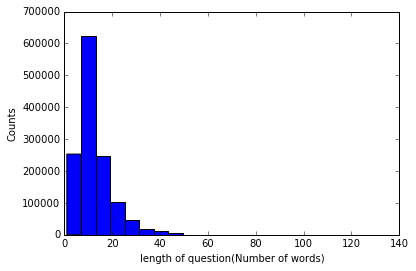

In [8]:
#how long a question is, on average?
sentence_length = \
train_csv["question_text"].apply(lambda x: x.split(" "))\
                          .apply(lambda x: len(x))\
                          .values

_ = plt.hist(sentence_length, bins=20)
plt.xlabel("length of question(Number of words)")
plt.ylabel("Counts")

pd.Series(sentence_length).describe()

In [9]:
#load the contractions 
contractions_map = pd.read_pickle("../nlp_training/CONTRACTION_MAP.pickle")

#load the stopwords
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

#load the spacy model
spacy_mod = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

#tokenizer 
tokenizer = ToktokTokenizer()

def remove_accented_chars(text):
    """
    Removes the accented characters and replaces them 
    with ascii values counterparts.
    INPUT:
        text: <str>
    """
    text = unicodedata.normalize('NFKD', text)\
                      .encode('ascii', 'ignore')\
                      .decode('utf-8', 'ignore')
    return text

def strip_html_tags(text):
    """
    Removes the html tags.
    INPUT:
        text: <str>
    """
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def expand_contractions(text, contraction_mapping=contractions_map):
    """
    Expands common phrase contractions.
    INPUT:
        text: <str> text to look for contractions and expand them
        contractions_map: <dict> containing the keys as the contractions 
                                and values the expanded versions 
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    """
    Removes the special characters from the text
    INPUT:
        text: <str> text to remove special characters
        remove_digit: <bool> option to remove the number digits 
                            in the text
    """
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, stopword_list, tokenizer, is_lower_case=False):
    """
    Removes the stopwords from the text 
    given a list of stopwords.
    INPUT:
        text: <str> text to remove the stopwords
        stopword_list: <list> containing the stopwords
        tokenizer: <python object> with tokenize() method that transforms
                        text to a list/iterable of tokens/words.
    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def lemmatize_text(text, nlp_mod=spacy_mod):
    """
    Transform the words/tokens to its root word.
    INPUT:
        text: <str> text to lemmatize
        spacy_model: <spacy object>
        
    """
    text = nlp_mod(text)
    text = ' '.join([word.lemma_ if (word.ent_iob_ == "O" and word.lemma_ != "-PRON-")
                     else word.text for word in text])
    return text


def text_preproc(text, html_stripping=True, contraction_expansion=True,
                 accented_char_removal=True, text_lower_case=False, 
                 text_lemmatization=True, special_char_removal=True, 
                 stopword_removal=True, remove_digits=True,
                 stopword_list=stopword_list, tokenizer=tokenizer):
    
    """
    Preprocess the text data.
    """
    
    # strip HTML
    if html_stripping:
        text = strip_html_tags(text)
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
    # lowercase the text    
    if text_lower_case:
        text = text.lower() #Standard text lower method
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    # lemmatize text
    if text_lemmatization:
        text = lemmatize_text(text)
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, stopword_list, tokenizer, is_lower_case=text_lower_case)
    
    return tokenizer.tokenize(text)

In [ ]:
#show an example of preprocessing
ind = 617
(text_preproc(train_csv["question_text"].iloc[ind], text_lower_case=False), 
 train_csv["question_text"].iloc[ind],
 train_csv["target"].iloc[ind])

(['US',
  'stop',
  'support',
  'Kosovo',
  'terrorist',
  'Albanians',
  'actually',
  'ISIS'],
 'When will the US stop supporting Kosovo terrorists (Albanians), who are actually the same as ISIS?',
 1)

In [ ]:
%%time
pool = mp.Pool(processes=mp.cpu_count()-3)
pool_res = pd.Series(pool.map(text_preproc, train_csv["question_text"].values))
pool.close()

In [ ]:
train_csv["preproc"] = pool_res
train_csv.head()

In [ ]:
#for each sincere and insincere questions, let's look at the top 20 most occurring words

#sincere questions
sincere_vocab = pd.value_counts(np.concatenate(train_csv[train_csv["target"]==0]["preproc"].values))
print(sincere_vocab.shape)
sincere_vocab.head(20)

In [ ]:
#insincere questions
insincere_vocab = pd.value_counts(np.concatenate(train_csv[train_csv["target"]==1]["preproc"].values))
print(insincere_vocab.shape)
insincere_vocab.head(20)

In [ ]:
#unique words all in all
len(np.unique(np.append(sincere_vocab.index, insincere_vocab.index)))

In [71]:
#let's assign numeric codes per word 

num_words = 100000 #let's consider only the top 100000 words 
keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_csv["preproc"].values)
train_csv[""]keras_tokenizer.texts_to_sequences(train_csv["preproc"].values)


In [75]:
keras_tokenizer.texts_to_sequences(train_csv["preproc"].values)

[[5168, 3744, 51, 3969, 594],
 [1515, 223, 4, 2232, 5, 1515, 2, 1180],
 [1728, 188, 13, 1728, 188, 354, 4446],
 [9945, 6471, 39710, 8, 30298, 6575],
 [686, 32683, 75274, 1950, 1132, 61, 4836],
 [7163, 3250, 25, 14719, 39711, 75275, 1587],
 [49, 2178, 706, 666, 399, 682, 2, 315, 257],
 [1332, 1855, 3374, 3952, 8270, 3086],
 [28, 1134, 14966, 79, 1134, 19408],
 [35,
  1627,
  11700,
  25,
  2662,
  5,
  65,
  809,
  7486,
  613,
  20,
  3,
  124,
  18,
  14,
  29,
  5542,
  5047,
  28,
  61],
 [36, 2316],
 [9842, 2353, 2285],
 [1561, 591, 2222, 138, 2014, 54, 1860],
 [8, 2150, 182, 3777, 2249, 226, 316, 2250, 316, 188],
 [63, 153, 52, 398, 4, 65, 398, 153, 2290, 685],
 [16, 24214, 16590, 75276, 2518],
 [541, 24, 1, 5796, 15, 105, 732],
 [3324, 553, 10702],
 [12, 567, 1515, 241, 858, 1459, 484, 1989, 354, 208, 77, 431],
 [19, 39712, 281, 278, 672, 3051, 45446],
 [16, 1023, 50, 103, 103],
 [25, 412, 4486, 556, 152, 508, 20],
 [298, 66, 25, 357, 4654, 38],
 [1527, 3400, 16, 2047, 1345, 328,